In [2]:
# ============================================================
# Exploratory Data Analysis (EDA) - Telco Customer Churn (IBM)
# Autor: Gianpiero Rick Huaricapcha
# ============================================================

# 1️⃣ Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# ============================================================
# 2️⃣ Cargar el dataset
# ============================================================

df = pd.read_excel("Customer_Churn_Dataset.xlsx")

# Vista rápida del dataset
print("Forma del dataset:", df.shape)
df.head()

# Comentario:
# El dataset contiene información sobre 7043 clientes y 23 variables.
# La variable objetivo es 'Churn', que indica si el cliente abandonó (Yes) o no (No).


Forma del dataset: (7043, 23)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [3]:
# ============================================================
# 3️⃣ Tipos de datos y estructura general
# ============================================================

df.info()

# Comentario:
# Vemos que hay variables numéricas (tenure, MonthlyCharges, TotalCharges)
# y categóricas (gender, Partner, Contract, PaymentMethod, etc.).
# Algunas variables como 'TotalCharges' podrían estar en formato objeto y deben convertirse a numérico.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Convertir TotalCharges a numérico (manejar errores)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Verificar cambio
df["TotalCharges"].dtypes


dtype('float64')

In [5]:
# ============================================================
# Estadísticas descriptivas
# ============================================================

# Numéricas
df.describe()

# Categóricas
df.describe(include=["object"])

# Comentario:
# Las estadísticas muestran que 'tenure' tiene un rango entre 0 y 72 meses,
# y que el promedio de 'MonthlyCharges' ronda los 64 USD.
# En las categóricas, notamos que la mayoría de clientes tiene contrato mensual.


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,3186-AJIEK,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [6]:
# ============================================================
# Valores faltantes
# ============================================================

missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

# Comentario:
# 'TotalCharges' tiene valores faltantes (convertidos a NaN).
# Podrían imputarse usando el promedio o eliminarse si son pocos registros.


,0
TotalCharges,11


In [7]:
# ============================================================
# Duplicados
# ============================================================

duplicates = df.duplicated().sum()
print("Cantidad de filas duplicadas:", duplicates)

# Comentario:
# Generalmente, el dataset no debería tener duplicados porque cada 'customerID' es único.
# Si existieran, se eliminarían con df.drop_duplicates().


Cantidad de filas duplicadas: 0


In [8]:
# ============================================================
# Outliers
# ============================================================

# Usaremos el método IQR (Interquartile Range) para detectar valores extremos
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
outliers = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers[col] = ((df[col] < lower) | (df[col] > upper)).sum()

pd.DataFrame.from_dict(outliers, orient='index', columns=['Outliers'])

# Comentario:
# Existen algunos outliers en las variables numéricas, sobre todo en 'TotalCharges',
# pero podrían representar clientes con uso prolongado, no necesariamente errores.


,Outliers
tenure,0
MonthlyCharges,0
TotalCharges,0


/tmp/ipython-input-2206896685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="MonthlyCharges", data=df, palette="Set2")


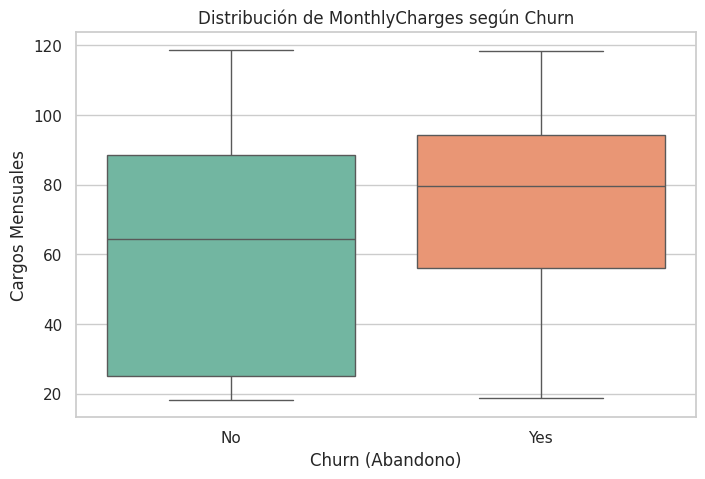

In [9]:
# ============================================================
# Visualización 1 - Boxplot: MonthlyCharges vs Churn
# ============================================================

sns.boxplot(x="Churn", y="MonthlyCharges", data=df, palette="Set2")
plt.title("Distribución de MonthlyCharges según Churn")
plt.xlabel("Churn (Abandono)")
plt.ylabel("Cargos Mensuales")
plt.show()

# Insight:
# Los clientes que abandonan (Yes) suelen tener cargos mensuales más altos.


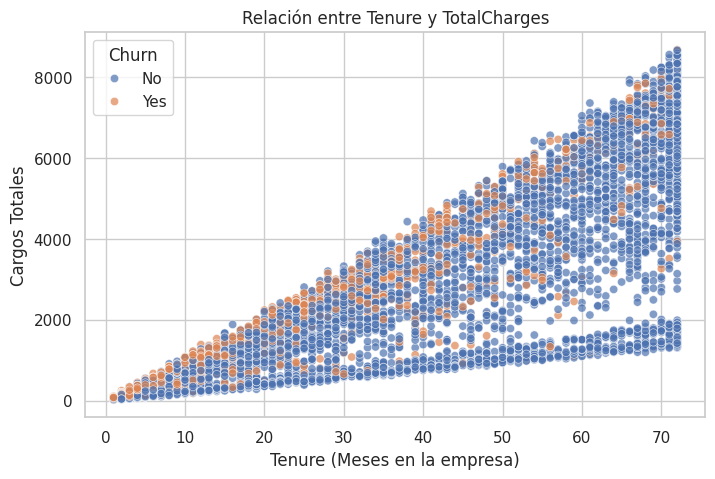

In [10]:
# ============================================================
# Visualización 2 - Scatterplot: tenure vs TotalCharges
# ============================================================

sns.scatterplot(x="tenure", y="TotalCharges", hue="Churn", data=df, alpha=0.7)
plt.title("Relación entre Tenure y TotalCharges")
plt.xlabel("Tenure (Meses en la empresa)")
plt.ylabel("Cargos Totales")
plt.show()

# Insight:
# Clientes con poca permanencia (tenure bajo) y bajos cargos totales tienden a abandonar.


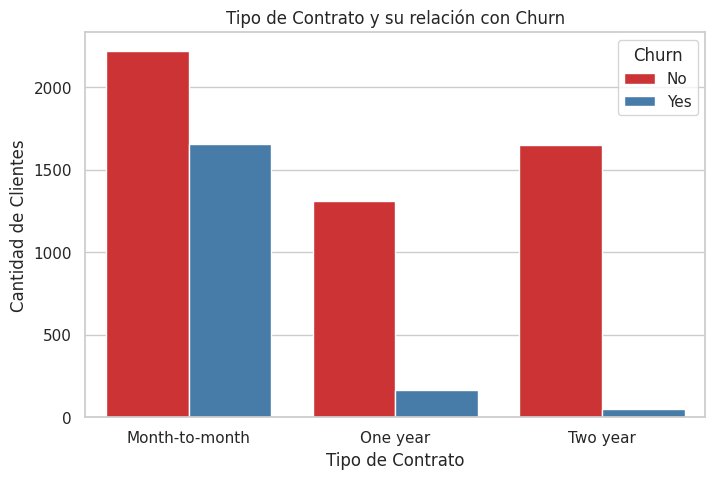

In [11]:
# ============================================================
# Visualización 3 - Countplot: Contract vs Churn
# ============================================================

sns.countplot(x="Contract", hue="Churn", data=df, palette="Set1")
plt.title("Tipo de Contrato y su relación con Churn")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad de Clientes")
plt.show()

# Insight:
# Los clientes con contratos mensuales tienen una tasa de abandono significativamente mayor.
